In this assignment, we will predict a toxictity of compounds using a neural network model (Mayr, Andreas, et al. "DeepTox: toxicity prediction using deep learning." Frontiers in Environmental Science 3 (2016): 80.). 

The given datasets are 'nr-ar.smiles' and 'nr-er.smiles' file. Each file contains 'smiles string of compound', 'array data', and 'activity value' (toxicity) at each raw. Activity value is marked as 0 when a compound is non-toxic, and 1 vice versa. 

We will use RDKit and Keras (tensorflow backend) package to build a prediction model. RDKit is most widely used python package for dealing chemical compounds. Keras is one of famous package for neural network.

Here, 
1) you need to build a neural network model for predicting the toxicity of compounds.
2) Train your model using the training dataset.
3) Report the ROC-AUC score of the test dataset using trained model.

In [0]:
# install rdkit library on colab environment

!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-09-24 06:45:11--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75257002 (72M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  71.77M   191MB/s    in 0.4s    

2019-09-24 06:45:12 (191 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [75257002/75257002]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==0.24.0=py37_0
    - bzip2==1.0.8=h7b6447c_0
    - ca-certificates==2019.5.15=0
    - certifi==2019.6.16=py37_0
    - cffi==1.12.3=py37h2e261b9_0
    - chardet==3.0.4=py37_1
    - conda-packag

In [0]:
#import basic python packages

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase

import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.backend import one_hot
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils

In [0]:
# load data from files

from google.colab import files
data_AR = files.upload() # select 'nr-ar.smiles' file and upload it
data_ER = files.upload() # select 'nr-er.smiels' file and upload it

Saving nr-ar.smiles to nr-ar.smiles


Saving nr-er.smiles to nr-er.smiles


In [0]:
# save the uploaded data as Pandas dataframe

import io
df_AR = pd.read_csv(io.BytesIO(data_AR['nr-ar.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])
df_ER = pd.read_csv(io.BytesIO(data_ER['nr-er.smiles']), sep = '\t', names = ['smiles', 'array', 'activity'])

smi_AR = df_AR['smiles']
smi_ER = df_ER['smiles']
activity_AR = df_AR['activity']
activity_ER = df_ER['activity']

In [0]:
# data preprocessing; convert SMILES string to 2048 bit Fingerprint.
def preprocessing(data_X, data_Y):
  data_x = []
  data_y = []
  for idx, smi in enumerate(data_X):
    try:
      arr = np.zeros((1,))
      mol = Chem.MolFromSmiles(smi) # convert 'smiles' string to 'mol' type
      fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) # convert 'mol' type to 2048 bit fingerprint 
      DataStructs.ConvertToNumpyArray(fp, arr) # convert fingerpint into array type
      data_x.append(arr)
      data_y.append(np.eye(2)[data_Y[idx]]) # convert label into one-hot encoding format
    except:
      pass
  return np.array(data_x), np.array(data_y)

data_X_AR, data_Y_AR = preprocessing(smi_AR, activity_AR)
data_X_ER, data_Y_ER = preprocessing(smi_ER, activity_ER)

# check the shape of the raw data
print(data_X_AR.shape)
print(data_Y_AR.shape)
print(data_X_ER.shape)
print(data_Y_ER.shape)

(9357, 2048)
(9357, 2)
(7693, 2048)
(7693, 2)


In [0]:
# split the training, validation and test dataset. train:validation:test=8:1:1

from sklearn.model_selection import train_test_split

#split training and test dataset from raw dataset
X_train_AR, X_test_AR, Y_train_AR, Y_test_AR = train_test_split(data_X_AR, data_Y_AR, test_size=0.1, random_state=42)
X_train_ER, X_test_ER, Y_train_ER, Y_test_ER = train_test_split(data_X_ER, data_Y_ER, test_size=0.1, random_state=42)
#split training and validation dataset from training dataset
X_train_AR, X_valid_AR, Y_train_AR, Y_valid_AR = train_test_split(X_train_AR, Y_train_AR, test_size=0.1111, random_state=42)
X_train_ER, X_valid_ER, Y_train_ER, Y_valid_ER = train_test_split(X_train_ER, Y_train_ER, test_size=0.1111, random_state=42)

# check the shape of the splited data

print(X_train_AR.shape, Y_train_AR.shape)
print(X_valid_AR.shape, Y_valid_AR.shape)
print(X_test_AR.shape, Y_test_AR.shape)
print(X_train_ER.shape, Y_train_ER.shape)
print(X_valid_ER.shape, Y_valid_ER.shape)
print(X_test_ER.shape, Y_test_ER.shape)

(7485, 2048) (7485, 2)
(936, 2048) (936, 2)
(936, 2048) (936, 2)
(6153, 2048) (6153, 2)
(770, 2048) (770, 2)
(770, 2048) (770, 2)


In [0]:
# build a neural network model with [input, hid_layer1, hid_layer2, hid_layer3, output]. 
# the number of hidden units are [512, 128, 32] respectively.
# the activation function of hidden layer is relu, and output is softmax.

inputs = Input(shape=(2048,), name='input') # input is 2048 bit fingerprint array that preprocessed above
hid_layer1 = Dense(512, activation='relu', name='Layer1')(inputs)
hid_layer2 = Dense(128, activation='relu', name='Layer2')(hid_layer1)
hid_layer3 = Dense(32, activation='relu', name='Layer3')(hid_layer2)
predictions = Dense(2, activation='softmax', name='output')(hid_layer3)

# make a prediction model for AR
model_AR = Model(inputs=inputs, outputs = predictions)
model_AR.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.00005),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
model_AR.summary() # print summary of AR model

# make a predictin model for ER
model_ER = Model(inputs=inputs, outputs = predictions)
model_ER.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.00005),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
model_ER.summary()# print summary of ER model






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
Layer1 (Dense)               (None, 512)               1049088   
_________________________________________________________________
Layer2 (Dense)               (None, 128)               65664     
_________________________________________________________________
Layer3 (Dense)               (None, 32)                4128      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 1,118,946
Trainable params: 1,118,946
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)               

In [0]:
# early stopping with validation dataset 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es_AR = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_AR = ModelCheckpoint('best_model_AR.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
es_ER = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc_ER = ModelCheckpoint('best_model_ER.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# training the model using training and validation set
epochs = 50
hist_AR = model_AR.fit(X_train_AR, Y_train_AR, validation_data=(X_valid_AR, Y_valid_AR), batch_size=32, epochs=epochs, verbose=0, callbacks=[es_AR, mc_AR])
hist_ER = model_ER.fit(X_train_ER, Y_train_ER, validation_data=(X_valid_ER, Y_valid_ER),batch_size=32, epochs=epochs, verbose=0, callbacks=[es_ER, mc_ER])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 00001: val_acc improved from -inf to 0.95513, saving model to best_model_AR.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:135: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '



Epoch 00002: val_acc improved from 0.95513 to 0.97436, saving model to best_model_AR.h5

Epoch 00003: val_acc did not improve from 0.97436

Epoch 00004: val_acc did not improve from 0.97436

Epoch 00005: val_acc did not improve from 0.97436

Epoch 00006: val_acc did not improve from 0.97436

Epoch 00007: val_acc did not improve from 0.97436

Epoch 00008: val_acc did not improve from 0.97436
Epoch 00008: early stopping

Epoch 00001: val_acc improved from -inf to 0.88312, saving model to best_model_ER.h5

Epoch 00002: val_acc improved from 0.88312 to 0.89610, saving model to best_model_ER.h5

Epoch 00003: val_acc improved from 0.89610 to 0.90000, saving model to best_model_ER.h5

Epoch 00004: val_acc improved from 0.90000 to 0.90649, saving model to best_model_ER.h5

Epoch 00005: val_acc did not improve from 0.90649

Epoch 00006: val_acc did not improve from 0.90649

Epoch 00007: val_acc did not improve from 0.90649

Epoch 00008: val_acc did not improve from 0.90649

Epoch 00009: val_ac

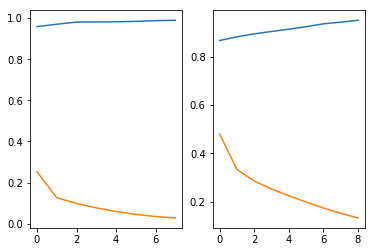

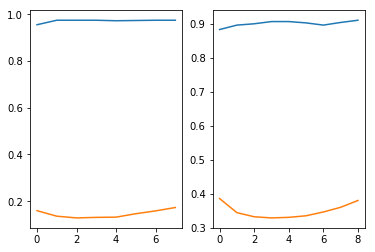

In [0]:
# plot the accuracy and loss value of each model.
fig_train, axs_train = plt.subplots(1, 2)
fig_valid, axs_valid = plt.subplots(1, 2)

axs_train[0].plot(hist_AR.history['acc'])
axs_train[0].plot(hist_AR.history['loss'])
axs_train[1].plot(hist_ER.history['acc'])
axs_train[1].plot(hist_ER.history['loss'])

axs_valid[0].plot(hist_AR.history['val_acc'])
axs_valid[0].plot(hist_AR.history['val_loss'])
axs_valid[1].plot(hist_ER.history['val_acc'])
axs_valid[1].plot(hist_ER.history['val_loss'])

In [0]:
from keras.models import load_model
saved_model_AR = load_model('best_model_AR.h5')
saved_model_AR.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.00005),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
saved_model_ER = load_model('best_model_ER.h5')
saved_model_ER.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.00005),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
train_loss_AR, train_acc_AR = saved_model_AR.evaluate(X_train_AR, Y_train_AR, verbose=0)
valid_loss_AR, valid_acc_AR = saved_model_AR.evaluate(X_valid_AR, Y_valid_AR, verbose=0)
test_loss_AR, test_acc_AR = saved_model_AR.evaluate(X_test_AR, Y_test_AR, verbose=0)
print('AR | Accuracy of Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc_AR, valid_acc_AR, test_acc_AR))
print('AR | Loss of Train: %.3f, Validation %.3f, Test: %.3f' % (train_loss_AR, valid_loss_AR, test_acc_AR))
print ()
train_loss_ER, train_acc_ER = saved_model_ER.evaluate(X_train_ER, Y_train_ER, verbose=0)
valid_loss_ER, valid_acc_ER = saved_model_ER.evaluate(X_valid_ER, Y_valid_ER, verbose=0)
test_loss_ER, test_acc_ER = saved_model_ER.evaluate(X_test_ER, Y_test_ER, verbose=0)
print('ER | Accuracy of Train: %.3f, Validation %.3f:, Test: %.3f' % (train_acc_ER, valid_acc_ER, test_acc_ER))
print('ER | Loss of Train: %.3f, Validation: %.3f, Test: %.3f' % (train_loss_ER, valid_loss_ER, test_acc_ER))

AR | Accuracy of Train: 0.980, Validation: 0.974, Test: 0.974
AR | Loss of Train: 0.107, Validation 0.136, Test: 0.974

ER | Accuracy of Train: 0.957, Validation 0.910:, Test: 0.877
ER | Loss of Train: 0.113, Validation: 0.381, Test: 0.877


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       902
           1       0.81      0.38      0.52        34

    accuracy                           0.97       936
   macro avg       0.89      0.69      0.75       936
weighted avg       0.97      0.97      0.97       936

AUC of AR: 0.6895134994130689

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       673
           1       0.52      0.29      0.37        97

    accuracy                           0.88       770
   macro avg       0.71      0.63      0.65       770
weighted avg       0.86      0.88      0.86       770

AUC of ER: 0.6250134035936948


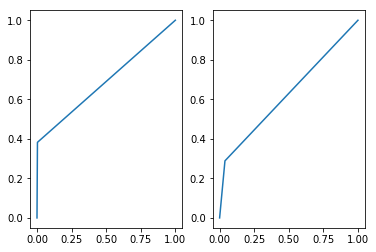

In [0]:
# evaluate the prediction model using test dataset.

from sklearn.metrics import classification_report, roc_curve, auc
fig, axs = plt.subplots(1, 2)
# AUC of AR dataset
Y_pred_AR = saved_model_AR.predict(X_test_AR)
Y_pred_AR = [np.argmax(y) for y in Y_pred_AR] # convert one-hot encoding to prediction label
Y_AR = [np.argmax(y) for y in Y_test_AR] # convert one-hot encoding to label
print(classification_report(Y_AR, Y_pred_AR))
# draw ROC-curve and calculate ROC-AUC
fpr, tpr, thresholds = roc_curve(Y_AR, Y_pred_AR, pos_label=1)
axs[0].plot(fpr, tpr)
print('AUC of AR: %s' %(auc(fpr, tpr)))
print()

# AUC of ER dataset
Y_pred_ER = saved_model_ER.predict(X_test_ER)
Y_pred_ER = [np.argmax(y) for y in Y_pred_ER]
Y_ER = [np.argmax(y) for y in Y_test_ER]
print(classification_report(Y_ER, Y_pred_ER))

fpr, tpr, thresholds = roc_curve(Y_ER, Y_pred_ER, pos_label=1)
axs[1].plot(fpr, tpr)
print('AUC of ER: %s' %(auc(fpr, tpr)))